In [1]:
# Import helpful libraries
from copy import deepcopy
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, \
    precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from scipy import stats
from yellowbrick.model_selection import LearningCurve, ValidationCurve, cv_scores
from yellowbrick.classifier import ROCAUC


# Utilities for this project
from transformers import ColumnsRemover, StringColumnsRemover, NullThresholdColumnsRemover
from loggers import ResultsLogger
logger = ResultsLogger()

# Hides warnings
import warnings
warnings.filterwarnings('ignore')

# Other helpful settings
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

train_data = pd.read_csv('./data/train.csv', index_col=0)
test_data = pd.read_csv('./data/test.csv', index_col=0)

print(train_data.shape, test_data.shape)

(891, 11) (418, 10)


In [2]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [44]:
df = train_data
y_column = 'Survived'

string_cols = list(df.select_dtypes(include=['object']).columns)
string_cols.remove('Name')
string_cols.remove('Cabin')
string_cols.remove('Embarked')
                   
numeric_cols = list(df.select_dtypes(include=['int64', 'float64']).columns)
numeric_cols.remove(y_column)

ignore_cols = ['Name', 'Cabin', 'Embarked']


print(f'{string_cols = }')
print(f'{numeric_cols = }')
print(f'{ignore_cols = }')

string_cols = ['Sex', 'Ticket']
numeric_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
ignore_cols = ['Name', 'Cabin', 'Embarked']


## EDA

In [51]:
df.groupby('SibSp')['Survived'].value_counts()

SibSp  Survived
0      0           398
       1           210
1      1           112
       0            97
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: Survived, dtype: int64

In [ ]:
def column_descriptive_analysis(
    df, col, crop=20, plot_function=sns.histplot, xticklabels=None, rotation=0, plot_kwargs={}
):
    percentiles = [0.01, 0.25, 0.50, 0.75, 0.99]
    
    description = df[col].describe(percentiles=percentiles).reset_index().rename(
        columns = {'index':'describe'}
    )
    value_counts = df[col].value_counts(dropna=False).reset_index().rename(
        columns = {'index':'value counts'}
    )
    norm_value_counts = df[col].value_counts(dropna=False, normalize=True).reset_index().rename(
        columns = {'index':'value percents'}
    )
    
    analysis = pd.concat([description, value_counts, norm_value_counts], ignore_index=False, axis=1)
    analysis = analysis.rename(columns = {col: ''})
    
    if crop:
        analysis = analysis[:crop]
    
    plot = plot_function(data=df, x=col, **plot_kwargs)
    
    if xticklabels:
        plot.set_xticks(np.arange(len(xticklabels)))
        plot.set_xticklabels(xticklabels)
    
        
    plt.suptitle(f'Coluna: {col}')
    plt.xticks(rotation=rotation)
    plt.show()
    
    print(f'Coluna: {col}')
    print(analysis.to_string(index=False))
    
    return analysis, plot

for col in df.columns:
    column_descriptive_analysis(df, col)


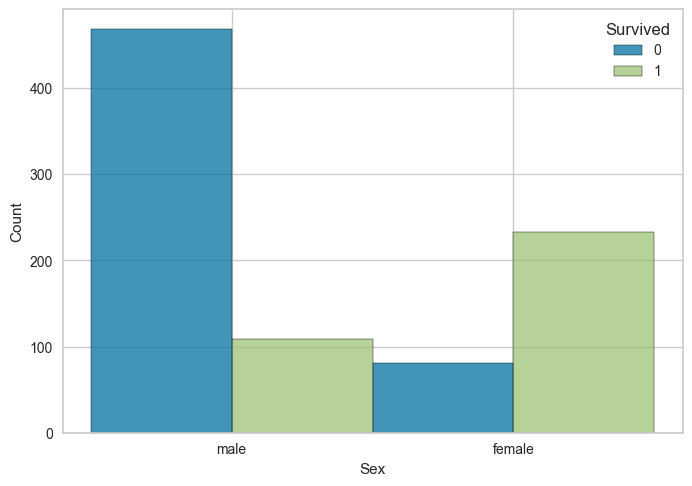

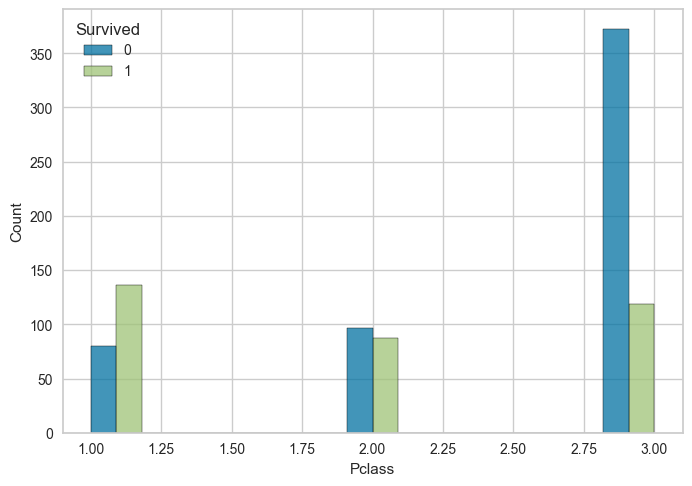

In [54]:
sns.histplot(
    data=df,
    x='Sex',
    hue=y_column,
    multiple='dodge',
    # kde=True,
)
plt.show()

sns.histplot(
    data=df,
    x='Pclass',
    hue=y_column,
    multiple='dodge',
    # kde=True,
)
plt.show()

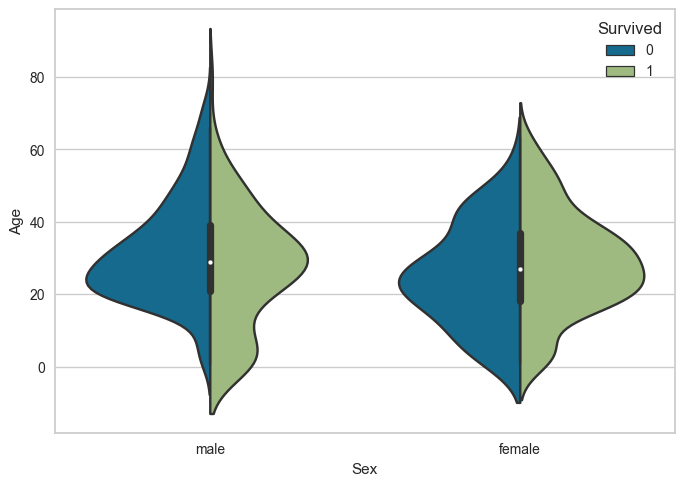

<AxesSubplot: xlabel='Pclass', ylabel='Age'>

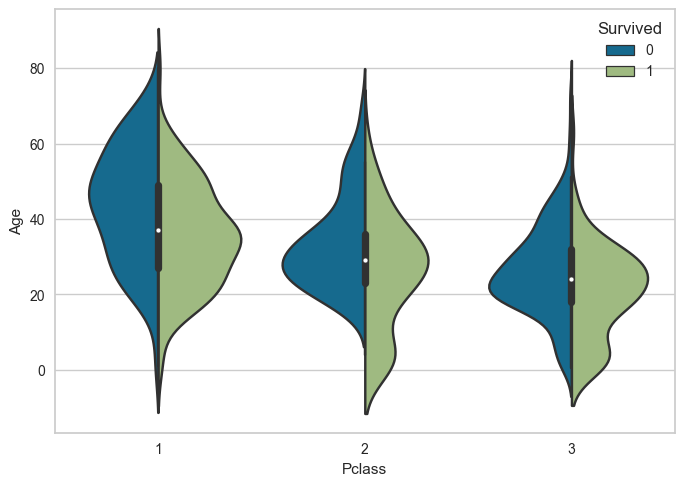

In [72]:
sns.violinplot(
    data=df,
    x="Sex",
    y="Age", 
    hue="Survived", 
    split=True
)
plt.show()

sns.violinplot(
    data=df,
    x="Pclass",
    y="Age", 
    hue="Survived", 
    split=True
)

In [ ]:
# for col in string_cols:
#     sns.histplot(
#         data=df,
#         x=col,
#         hue=y_column,
#         multiple='dodge',
#         # kde=True,
#     )
#     plt.show()

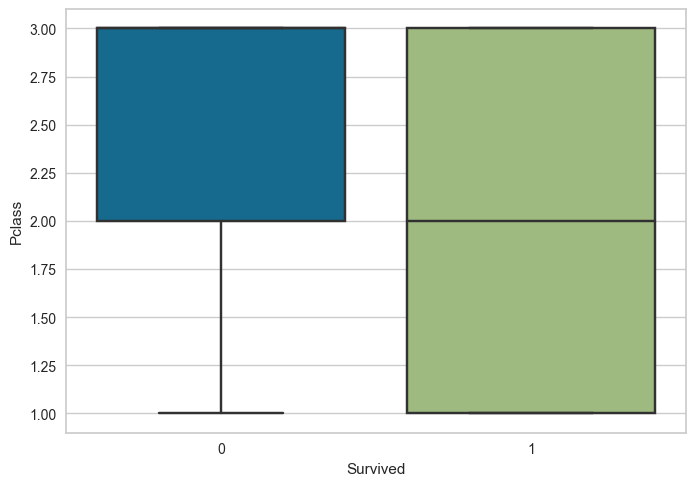

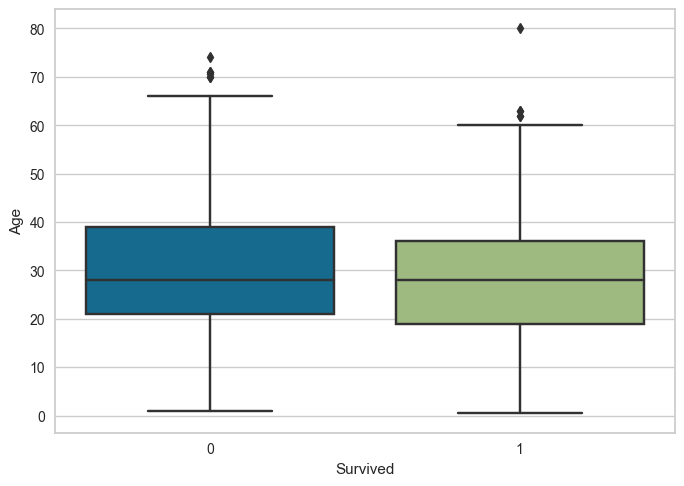

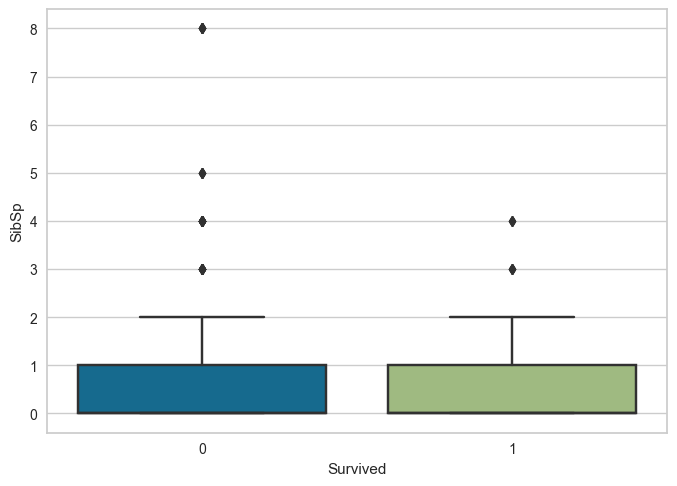

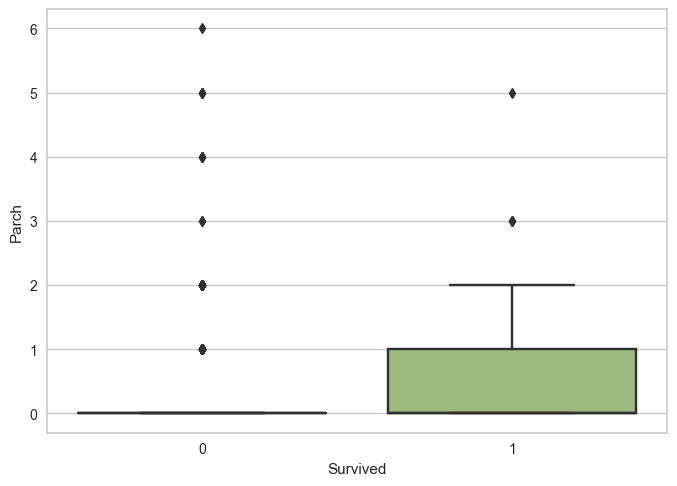

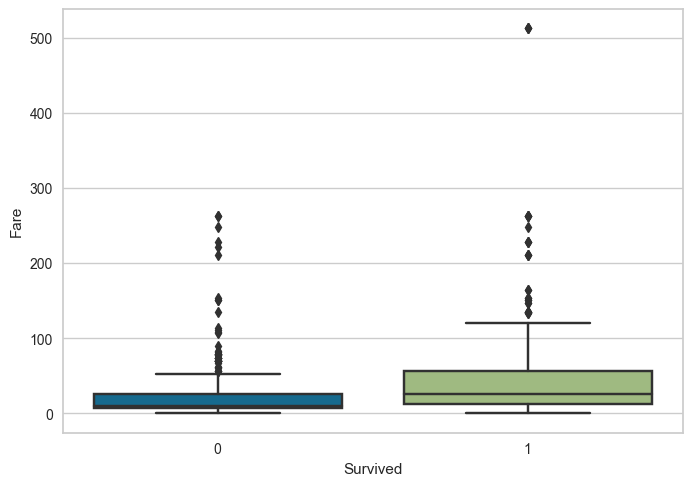

In [15]:
for col in numeric_cols:
    sns.boxplot(
        data=df,
        y=col,
        x=y_column,
    )
    plt.show()

## Pre Processing

In [6]:
df[y_column].value_counts()/df.shape[0]

0   0.62
1   0.38
Name: Survived, dtype: float64

### Null values

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
Age        0.20
Cabin      0.77
Embarked   0.00
dtype: float64


<AxesSubplot: >

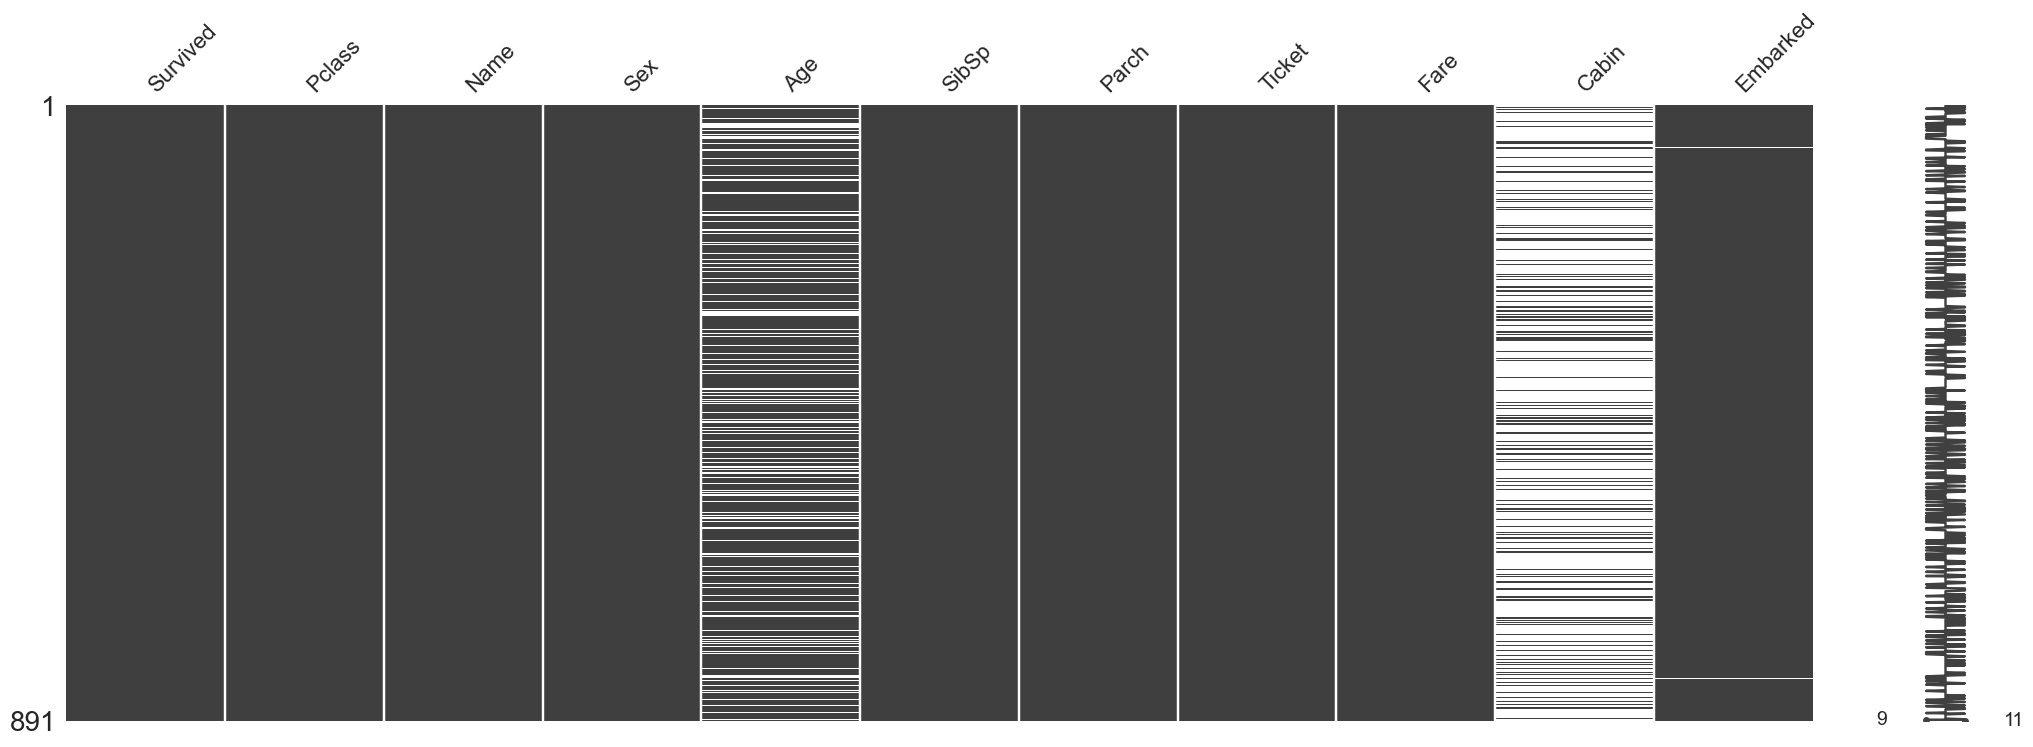

In [7]:
print(df.isnull().sum())
column_nulls = df.isnull().sum() / df.shape[0]
print(column_nulls[column_nulls > 0])

msno.matrix(df, figsize=(25,8))

## Outliers

## String columns

## Pre Processing

In [8]:
ignore_cols = ['Name', 'Ticket', 'Cabin',]


# Defining Pipelines
numeric_pipeline = Pipeline([
    ('remove_null_cols', NullThresholdColumnsRemover(threshold=0.25)),
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler()),  
])

string_pipeline = Pipeline([
    # ('remove_string_cols', StringColumnsRemover()),
    ('ignore_cols', ColumnsRemover(remove_cols=ignore_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder()),
])

processor = ColumnTransformer(
    transformers=[
        ('numeric_pipeline', numeric_pipeline, numeric_cols),
        ('string_pipeline', string_pipeline, string_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [9]:
raw_X = df.drop(y_column, axis=1)
Y = df[y_column]
print(raw_X.shape, Y.shape)

(891, 10) (891,)


In [10]:
processor.fit(raw_X)
processor_results = processor.transform(raw_X)

X = pd.DataFrame(
    processor_results, 
    columns=processor.get_feature_names_out()
)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    float64
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    float64
 3   Parch       891 non-null    float64
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    float64
 6   Sex_male    891 non-null    float64
 7   Embarked_C  891 non-null    float64
 8   Embarked_Q  891 non-null    float64
 9   Embarked_S  891 non-null    float64
dtypes: float64(10)
memory usage: 69.7 KB


## Train

### Data Split

In [11]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(668, 10) (223, 10) (668,) (223,)


### Model Selection

#### Logistical Regression

In [174]:
lr_model = LogisticRegression(
    solver='liblinear',
    max_iter=100,
    C=0.4
)

#### Random Forest

In [154]:
rf_model = RandomForestClassifier(
    n_estimators=75,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=15,
)

### Train Metrics

In [175]:
# Select model
train_model = lr_model  # LogisticRegression
# train_model = rf_model  # RandomForestClassifier

train_model.fit(train_X, train_y)
train_predictions = train_model.predict(val_X)

In [ ]:
# viz = ValidationCurve(
#     train_model,
#     param_name="C", 
#     param_range=np.linspace(0.01, 1, 11),
#     # logx=True, param_range=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     cv=5,
#     scoring="accuracy"
# )

# viz.fit(train_X, train_y)
# viz.show()

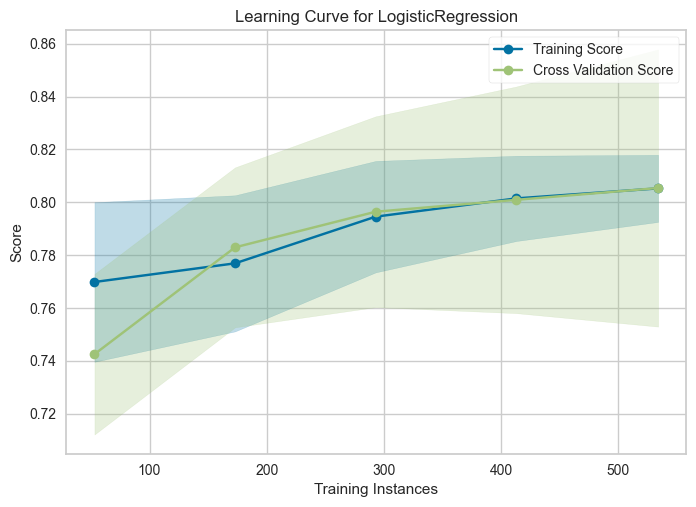

<AxesSubplot: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [196]:
visualizer = LearningCurve(
    train_model,
    cv=5,
    scoring="accuracy"
)

visualizer.fit(train_X, train_y)       
visualizer.show()   

### Log Metrics

In [177]:
# Get metrics
mae = mean_absolute_error(val_y, train_predictions)
r2 = r2_score(val_y, train_predictions)
f1 = f1_score(val_y, train_predictions)
accuracy = accuracy_score(val_y, train_predictions)
precision = precision_score(val_y, train_predictions)
recall = recall_score(val_y, train_predictions)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"F1: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

MAE: 0.20179372197309417
R2: 0.17475328947368407
F1: 0.7457627118644067
Accuracy: 0.7982062780269058
Precision: 0.8048780487804879
Recall: 0.6947368421052632


In [178]:
# Log metrics from experiment
kwargs = {
    'mean_absolute_error': mae, 
    'r2_score': r2, 
    'f1_score': f1,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'pipeline': processor,
    'model': train_model,
}
logger.log_result(**kwargs)

# Test

In [180]:
# Saving passangerIds from index
passengerIds = test_data.index

# Apply tronsforms to test data
test_processed_results = processor.transform(test_data)

test_X = pd.DataFrame(
    test_processed_results, 
    columns=processor.get_feature_names_out()
)

test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    float64
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    float64
 3   Parch       418 non-null    float64
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    float64
 6   Sex_male    418 non-null    float64
 7   Embarked_C  418 non-null    float64
 8   Embarked_Q  418 non-null    float64
 9   Embarked_S  418 non-null    float64
dtypes: float64(10)
memory usage: 32.8 KB


In [181]:
test_X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.00,0.50,0.00,0.00,-0.29,0.00,1.00,0.00,1.00,0.00
1,0.00,1.46,1.00,0.00,-0.32,1.00,0.00,0.00,0.00,1.00
2,-1.00,2.62,0.00,0.00,-0.21,0.00,1.00,0.00,1.00,0.00
3,0.00,-0.08,0.00,0.00,-0.25,0.00,1.00,0.00,0.00,1.00
4,0.00,-0.46,1.00,1.00,-0.09,1.00,0.00,0.00,0.00,1.00


In [191]:
# Define a random forest model
# test_model = train_model

# # Train and predict with the model
# test_model.fit(X, Y)
# test_predictions = test_model.predict(test_X)


test_predictions = train_model.predict(test_X)


In [192]:
final_predictions = pd.DataFrame(data={
    'PassengerId': test_data.index,
    'Survived': test_predictions
})

print(final_predictions.Survived.value_counts())
print(final_predictions.Survived.value_counts(normalize=True))

0    263
1    155
Name: Survived, dtype: int64
0   0.63
1   0.37
Name: Survived, dtype: float64


### Exporting results

In [193]:
EXPORT = False

if EXPORT:
    final_predictions.to_csv('submission.csv', index=False)